## Prerequisites
본 `ipynb` 은 `Python=3.12` 에서 작성하였습니다. Package dependency 를 해결하기 위해 아래 cell 을 실행해주세요.

## Install Python packages

In [ ]:
%pip -q install -U google-genai openai matplotlib python-slugify

## Load environment variables from a .env file
secret 노출을 피하고 notebook 들간의 일관된 환경변수를 설정하기 위해 `dotenv` 을 이용한다.

In [71]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

WORKING_DIR = "experiments/007-comparison-of-vision-models"
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_SECONDARY_ENDPOINT = os.getenv("AZURE_OPENAI_SECONDARY_ENDPOINT")
AZURE_OPENAI_SECONDARY_API_KEY = os.getenv("AZURE_OPENAI_SECONDARY_API_KEY")
AZURE_OPENAI_SECONDARY_IMAGE_DEPLOYMENT = os.getenv("AZURE_OPENAI_SECONDARY_IMAGE_DEPLOYMENT")
AZURE_OPENAI_SECONDARY_IMAGE_MINI_DEPLOYMENT = os.getenv("AZURE_OPENAI_SECONDARY_IMAGE_MINI_DEPLOYMENT")
AZURE_OPENAI_SECONDARY_IMAGE_1_5_DEPLOYMENT = os.getenv("AZURE_OPENAI_SECONDARY_IMAGE_1_5_DEPLOYMENT")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GOOGLE_IMAGE_DEPLOYMENT = os.getenv("GOOGLE_IMAGE_DEPLOYMENT")
GOOGLE_SECONDARY_IMAGE_DEPLOYMENT = os.getenv("GOOGLE_SECONDARY_IMAGE_DEPLOYMENT")
AZURE_BLACKFOREST_API_KEY = os.getenv("AZURE_BLACKFOREST_API_KEY")
AZURE_BLACKFOREST_GENERATION_ENDPOINT = os.getenv("AZURE_BLACKFOREST_GENERATION_ENDPOINT")
AZURE_BLACKFOREST_FLUX_2_PRO_GENERATION_ENDPOINT = os.getenv("AZURE_BLACKFOREST_FLUX_2_PRO_GENERATION_ENDPOINT")
AZURE_BLACKFOREST_EDIT_ENDPOINT = os.getenv("AZURE_BLACKFOREST_EDIT_ENDPOINT")
AZURE_BLACKFOREST_IMAGE_DEPLOYMENT = os.getenv("AZURE_BLACKFOREST_IMAGE_DEPLOYMENT")
AZURE_BLACKFOREST_IMAGE_FLUX_2_PRO_DEPLOYMENT = os.getenv("AZURE_BLACKFOREST_IMAGE_FLUX_2_PRO_DEPLOYMENT")

## Image Generation

### Define functions to evaluate model capabilties

In [72]:
from google import genai
from openai import OpenAI

aoai_client = OpenAI(base_url=AZURE_OPENAI_SECONDARY_ENDPOINT, api_key=AZURE_OPENAI_SECONDARY_API_KEY)
google_client = genai.Client(api_key=GOOGLE_API_KEY)

In [93]:
import asyncio
import base64
import requests
from pathlib import Path
import time
import pandas as pd

from google.genai import types
from slugify import slugify

async def generate_image(task: str, prompt: str, path: Path, count: int = 10) -> None:
    def generate_image_by_google(prompt: str, path: Path, index: int, model: str) -> None:
        start = time.perf_counter()
        response = google_client.models.generate_content(
            model=model,
            contents=prompt,
            config=types.GenerateContentConfig(
                image_config=types.ImageConfig(aspect_ratio="1:1"),
            ),
        )
        end = time.perf_counter()
        
        for part in response.parts:
            if image:= part.as_image():
                path = path / f"{task}_{slugify(model)}_{index}.png"
                image.save(path)
                
        input_tokens_usage = response.usage_metadata.prompt_token_count
        output_tokens_usage = response.usage_metadata.total_token_count
        
        return path, end - start, input_tokens_usage, output_tokens_usage
        
    def generate_image_by_azure(prompt: str, path: Path, index: int, model: str) -> None:
        start = time.perf_counter()
        response = aoai_client.images.generate(
            model=model,
            prompt=prompt,
            n=1,
            size="1024x1024"
        )
        end = time.perf_counter()
        
        path = path / f"{task}_{slugify(model)}_{index}.png"
        image_bytes = base64.b64decode(response.data[0].b64_json)
        with open(path, "wb") as f:
            f.write(image_bytes)
            
        input_tokens_usage = response.usage.input_tokens
        output_tokens_usage = response.usage.output_tokens
        
        return path, end - start, input_tokens_usage, output_tokens_usage
    
    def generate_image_by_blackforest(prompt: str, path: Path, index: int) -> None:
        count = 0
        max_retries = 10
        while True:
            try:
                start = time.perf_counter()
                response = requests.post(
                    url=AZURE_BLACKFOREST_GENERATION_ENDPOINT,
                    headers={"Api-Key": AZURE_BLACKFOREST_API_KEY},
                    # refer to https://docs.bfl.ml/kontext/kontext_text_to_image
                    json={"prompt": prompt, "aspect_ratio": "1:1"},
                )
                end = time.perf_counter()
                if response.status_code == 200:
                    break
            except requests.ReadTimeout:
                ...

            count += 1
            if count >= max_retries:
                raise Exception("Max retries exceeded for Blackforest image edit.")
            time.sleep(1.5 ** count)  # Exponential backoff

        path = path / f"{task}_{slugify(AZURE_BLACKFOREST_IMAGE_DEPLOYMENT)}_{index}.png"
        image_bytes = base64.b64decode(response.json()["data"][0]["b64_json"])
        with open(path, "wb") as f:
            f.write(image_bytes)
        return path, end - start, 0, 0

    def generate_image_by_blackforest_flux_2_pro(prompt: str, path: Path, index: int) -> None:
        count = 0
        max_retries = 10
        while True:
            try:
                start = time.perf_counter()
                response = requests.post(
                    url=AZURE_BLACKFOREST_FLUX_2_PRO_GENERATION_ENDPOINT,
                    headers={"Authorization": f"Bearer {AZURE_BLACKFOREST_API_KEY}"},
                    # refer to https://docs.bfl.ml/kontext/kontext_text_to_image
                    json={
                        "prompt" : prompt,
                        "size" : "1024x1024",
                        "n" : 1,
                        "model" : "flux.2-pro"
                    }
                )
                end = time.perf_counter()
                if response.status_code == 200:
                    break
            except requests.ReadTimeout:
                ...

            count += 1
            if count >= max_retries:
                raise Exception("Max retries exceeded for Blackforest image edit.")
            time.sleep(1.5 ** count)  # Exponential backoff

        path = path / f"{task}_{slugify(AZURE_BLACKFOREST_IMAGE_FLUX_2_PRO_DEPLOYMENT)}_{index}.png"
        image_bytes = base64.b64decode(response.json()["data"][0]["b64_json"])
        with open(path, "wb") as f:
            f.write(image_bytes)
        return path, end - start, 0, 0

    path = path / "generated_image"
    path.mkdir(parents=True, exist_ok=True)

    results = await asyncio.gather(
        *[asyncio.to_thread(
            generate_image_by_azure, prompt, path, i, AZURE_OPENAI_SECONDARY_IMAGE_DEPLOYMENT,
        ) for i in range(count)],
        *[asyncio.to_thread(
            generate_image_by_azure, prompt, path, i, AZURE_OPENAI_SECONDARY_IMAGE_MINI_DEPLOYMENT,
        ) for i in range(count)],
        *[asyncio.to_thread(
            generate_image_by_azure, prompt, path, i, AZURE_OPENAI_SECONDARY_IMAGE_1_5_DEPLOYMENT,
        ) for i in range(count)],
        *[asyncio.to_thread(
            generate_image_by_google, prompt, path, i, GOOGLE_IMAGE_DEPLOYMENT,
        ) for i in range(count)],
        *[asyncio.to_thread(
            generate_image_by_google, prompt, path, i, GOOGLE_SECONDARY_IMAGE_DEPLOYMENT,
        ) for i in range(count)],
        *[asyncio.to_thread(
            generate_image_by_blackforest, prompt, path, i,
        ) for i in range(count)],
        *[asyncio.to_thread(
            generate_image_by_blackforest_flux_2_pro, prompt, path, i,
        ) for i in range(count)],
    )

    records = []
    for i, (img_path, elapsed, input_tokens_usage, output_tokens_usage) in enumerate(results):
        provider = (
            AZURE_OPENAI_SECONDARY_IMAGE_DEPLOYMENT if i < count
            else AZURE_OPENAI_SECONDARY_IMAGE_MINI_DEPLOYMENT if i < 2 * count
            else AZURE_OPENAI_SECONDARY_IMAGE_1_5_DEPLOYMENT if i < 3 * count
            else GOOGLE_IMAGE_DEPLOYMENT if i < 4 * count
            else GOOGLE_SECONDARY_IMAGE_DEPLOYMENT if i < 5 * count
            else AZURE_BLACKFOREST_IMAGE_DEPLOYMENT if i < 6 * count
            else AZURE_BLACKFOREST_IMAGE_FLUX_2_PRO_DEPLOYMENT
        )
        idx = (
            i if i < count
            else i - count if i < 2 * count
            else i - 2 * count if i < 3 * count
            else i - 3 * count if i < 4 * count
            else i - 4 * count if i < 5 * count
            else i - 5 * count if i < 6 * count
            else i - 6 * count
        )
        records.append({
            "capability": "image_generation",
            "task": task,
            "provider": provider,
            "index": idx,
            "path": str(img_path),
            "elapsed_sec": elapsed,
            "input_tokens_usage": input_tokens_usage,
            "output_tokens_usage": output_tokens_usage,
        })

    return pd.DataFrame(records)

### Test Execution

In [94]:
IMAGE_GENERATION_PROMPT_SHORT = "a cute cat sitting on a chair"
IMAGE_GENERATION_PROMPT_MEDIUM = (
    "a futuristic cityscape at night with towering skyscrapers, flying cars, and neon lights, "
    "reflecting a cyberpunk aesthetic with a bustling atmosphere and advanced technology"
)
IMAGE_GENERATION_PROMPT_LONG = """
Render a realistic image of this character:
Blobby Alien Character Spec Name: Glorptak (or nickname: "Glorp")
Visual Appearance Body Shape: Amorphous and gelatinous. Overall silhouette resembles a teardrop or melting marshmallow, shifting slightly over time. Can squish and elongate when emotional or startled.
Material Texture: Semi-translucent, bio-luminescent goo with a jelly-like wobble. Surface occasionally ripples when communicating or moving quickly.
Color Palette:
- Base: Iridescent lavender or seafoam green
- Accents: Subsurface glowing veins of neon pink, electric blue, or golden yellow
- Mood-based color shifts (anger = dark red, joy = bright aqua, fear = pale gray)
Facial Features:
- Eyes: 3–5 asymmetrical floating orbs inside the blob that rotate or blink independently
- Mouth: Optional—appears as a rippling crescent on the surface when speaking or emoting
- No visible nose or ears; uses vibration-sensitive receptors embedded in goo
- Limbs: None by default, but can extrude pseudopods (tentacle-like limbs) when needed for interaction or locomotion. Can manifest temporary feet or hands.
Movement & Behavior Locomotion:
- Slides, bounces, and rolls.
- Can stick to walls and ceilings via suction. When scared, may flatten and ooze away quickly.
Mannerisms:
- Constant wiggling or wobbling even at rest
- Leaves harmless glowing slime trails
- Tends to absorb nearby small objects temporarily out of curiosity
"""

results = pd.DataFrame()
for prompt, name in [
    (IMAGE_GENERATION_PROMPT_SHORT, "short_prompt"),
    (IMAGE_GENERATION_PROMPT_MEDIUM, "medium_prompt"),
    (IMAGE_GENERATION_PROMPT_LONG, "long_prompt"),
]:
     results = pd.concat(
         [results, await generate_image(name, prompt, Path(WORKING_DIR), count=3)],
     )
results

,capability,task,provider,index,path,elapsed_sec,input_tokens_usage,output_tokens_usage
0,image_generation,short_prompt,gpt-image-1,0,experiments/007-comparison-of-vision-models/ge...,43.740421,13,4160
1,image_generation,short_prompt,gpt-image-1,1,experiments/007-comparison-of-vision-models/ge...,48.382115,13,4160
2,image_generation,short_prompt,gpt-image-1,2,experiments/007-comparison-of-vision-models/ge...,43.691050,13,4160
3,image_generation,short_prompt,gpt-image-1-mini,0,experiments/007-comparison-of-vision-models/ge...,34.760852,13,4160
4,image_generation,short_prompt,gpt-image-1-mini,1,experiments/007-comparison-of-vision-models/ge...,46.981745,13,4160
...,...,...,...,...,...,...,...,...
16,image_generation,long_prompt,flux.1-kontext-pro,1,experiments/007-comparison-of-vision-models/ge...,5.538703,0,0
17,image_generation,long_prompt,flux.1-kontext-pro,2,experiments/007-comparison-of-vision-models/ge...,5.545747,0,0
18,image_generation,long_prompt,flux.2-pro,0,experiments/007-comparison-of-vision-models/ge...,7.843635,0,0
19,image_generation,long_prompt,flux.2-pro,1,experiments/007-comparison-of-vision-models/ge...,7.231716,0,0


### Drawing evaluation result

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_evaluation_results(df):
    df = df.copy()
    df["total_tokens"] = df["input_tokens_usage"] + df["output_tokens_usage"]

    # 집계: task + provider 별 평균
    summary = (
        df.groupby(["task", "provider"], as_index=False)[
            ["elapsed_sec", "total_tokens"]
        ].mean()
    )

    tasks = summary["task"].unique().tolist()
    providers = sorted(summary["provider"].unique().tolist())  # 동적 provider 목록
    n_tasks = len(tasks)
    n_prov = len(providers)

    x_task = np.arange(n_tasks)

    # 한 task 안에 latency n_prov 개 + tokens n_prov 개 = 2 * n_prov 막대
    group_width = 0.8
    n_bars = 2 * n_prov
    bar_spacing = group_width / max(n_bars, 1)

    # offsets: 왼쪽부터 오른쪽까지 균등 배치
    idx = np.arange(n_bars) - (n_bars - 1) / 2.0
    offsets = idx * bar_spacing

    # 스타일
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams.update({
        "font.size": 11,
        "font.family": "serif",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
    })

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    # color cycle 에서 provider 별 색 할당
    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    provider_colors = {
        prov: color_cycle[i % len(color_cycle)]
        for i, prov in enumerate(providers)
    }

    bars_to_annotate = []

    for t_idx, task in enumerate(tasks):
        task_center = x_task[t_idx]

        for p_idx, prov in enumerate(providers):
            row = summary[(summary["task"] == task) & (summary["provider"] == prov)]

            if row.empty:
                lat = 0.0
                tok = 0.0
            else:
                lat = row["elapsed_sec"].values[0]
                tok = row["total_tokens"].values[0]

            # latency index: 0 ~ n_prov-1
            # tokens index: n_prov ~ 2*n_prov-1
            lat_offset = offsets[p_idx]
            tok_offset = offsets[n_prov + p_idx]

            color = provider_colors[prov]

            # ---- Latency (왼쪽 축, hatch) ----
            x_lat = task_center + lat_offset
            bar_lat = ax1.bar(
                x_lat,
                lat,
                width=bar_spacing * 0.75,
                color="white",
                edgecolor=color,
                hatch="///",
                linewidth=1.3,
            )
            bars_to_annotate.append((bar_lat, lat, ax1))

            # ---- Tokens (오른쪽 축, solid) ----
            x_tok = task_center + tok_offset
            bar_tok = ax2.bar(
                x_tok,
                tok,
                width=bar_spacing * 0.75,
                color=color,
                alpha=0.9,
            )
            bars_to_annotate.append((bar_tok, tok, ax2))

    # ---- Y축 여유 (legend/label 겹침 방지) ----
    max_latency = summary["elapsed_sec"].max() if not summary.empty else 1.0
    max_tokens = summary["total_tokens"].max() if not summary.empty else 1.0
    ax1.set_ylim(0, max_latency * 1.25 if max_latency > 0 else 1.0)
    ax2.set_ylim(0, max_tokens * 1.25 if max_tokens > 0 else 1.0)

    # ---- 값 표시 ----
    for bar, value, axis in bars_to_annotate:
        for rect in bar:
            height = rect.get_height()
            axis.annotate(
                f"{value:.2f}" if axis is ax1 else f"{int(value)}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=8,
            )

    # ---- 축 / 라벨 ----
    ax1.set_ylabel("Latency (sec)", fontsize=12)
    ax2.set_ylabel("Token Usage (tokens)", fontsize=12)

    ax1.set_xticks(x_task)
    ax1.set_xticklabels(tasks, fontsize=11)
    ax1.set_xlabel("Task (Prompt Type)", fontsize=12)

    # Y축 tick fontsize = 8
    ax1.tick_params(axis="y", labelsize=8)
    ax2.tick_params(axis="y", labelsize=8)

    ax1.grid(False)
    ax2.grid(False)

    # ---- capability 를 title 에 반영 ----
    capability = None
    if "capability" in df.columns:
        caps = sorted(df["capability"].unique().tolist())
        capability = ", ".join(caps)
    title_prefix = f"{capability} - " if capability else ""

    fig.suptitle(
        f"{title_prefix}Latency & Token Usage by Provider and Prompt Type",
        fontsize=14,
        fontweight="bold",
    )

    # ---- Legend (동적 provider) ----
    legend_items = []

    for prov in providers:
        color = provider_colors[prov]

        # Latency (hatch + provider color edge)
        legend_items.append(
            Patch(
                facecolor="white",
                edgecolor=color,
                hatch="///",
                linewidth=1.3,
                label=f"{prov.capitalize()} L"
            )
        )

        # Tokens (solid provider color)
        legend_items.append(
            Patch(
                facecolor=color,
                edgecolor=color,
                label=f"{prov.capitalize()} T"
            )
        )

    ax1.legend(
        handles=legend_items,
        loc="upper center",
        #bbox_to_anchor=(0.5, 1.25),
        ncol=len(providers),
        frameon=True,
        fontsize=6,
    )

    fig.tight_layout()
    plt.show()

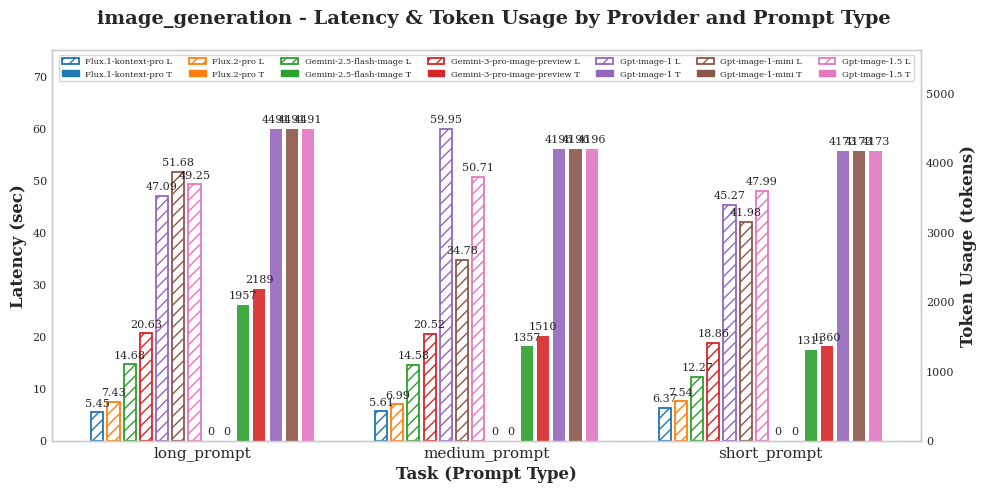

In [95]:
plot_evaluation_results(results)

## Image Object Removal

### Define functions to evaluate model capabilties

In [89]:
import asyncio
import base64
import requests
import pandas as pd
from pathlib import Path
import time

from google.genai import types
from PIL import Image
from slugify import slugify

async def remove_image_object(task: str, prompt: str, input_path: Path, count: int = 10, size: int = 1024):
    def remove_object_by_azure(prompt: str, input_path: Path, index: int, model: str) -> None:
        start = time.perf_counter()
        if model == AZURE_OPENAI_SECONDARY_IMAGE_MINI_DEPLOYMENT:
            response = aoai_client.images.edit(
                model=model,
                image=open(input_path, "rb"),
                prompt=prompt,
                n=1,
                size=f"{size}x{size}",
            )
        else:
            response = aoai_client.images.edit(
                model=model,
                image=open(input_path, "rb"),
                prompt=prompt,
                n=1,
                size=f"{size}x{size}",
                input_fidelity="high",
            )
        end = time.perf_counter()

        path = input_path.with_stem(input_path.stem + f"_output_{slugify(model)}_{index}")
        image_bytes = base64.b64decode(response.data[0].b64_json)
        with open(path, "wb") as f:
            f.write(image_bytes)

        input_tokens_usage = response.usage.input_tokens
        output_tokens_usage = response.usage.output_tokens

        return path, end - start, input_tokens_usage, output_tokens_usage

    def remove_object_by_google(prompt: str, input_path: Path, index: int, model: str) -> None:
        start = time.perf_counter()
        input_image = Image.open(input_path)
        response = google_client.models.generate_content(
            model=model,
            contents=[input_image, prompt],
            config=types.GenerateContentConfig(
                image_config=types.ImageConfig(aspect_ratio="1:1"),
            ),
        )
        end = time.perf_counter()

        for part in response.parts:
            if image:= part.as_image():
                path = input_path.with_stem(input_path.stem + f"_output_{slugify(model)}_{index}")
                image.save(path)

        input_tokens_usage = response.usage_metadata.prompt_token_count
        output_tokens_usage = response.usage_metadata.total_token_count

        return path, end - start, input_tokens_usage, output_tokens_usage

    def remove_object_by_blackforest(prompt: str, input_path: Path, index: int) -> None:
        count = 0
        max_retries = 10
        while True:
            try:
                start = time.perf_counter()
                response = requests.post(
                    url=AZURE_BLACKFOREST_EDIT_ENDPOINT,
                    headers={"Api-Key": AZURE_BLACKFOREST_API_KEY},
                    # refer to https://docs.bfl.ml/kontext/kontext_image_editing
                    data={"model": AZURE_BLACKFOREST_IMAGE_DEPLOYMENT, "prompt": prompt},
                    files={
                        "image": (
                            input_path.name,
                            open(input_path, "rb"),
                            f"image/{input_path.suffix.lstrip('.')}",
                        )
                    }
                )
                end = time.perf_counter()
                if response.status_code == 200:
                    break
            except requests.ReadTimeout:
                ...

            count += 1
            if count >= max_retries:
                raise Exception("Max retries exceeded for Blackforest image edit.")
            time.sleep(1.5 ** count)  # Exponential backoff

        path = input_path.with_stem(input_path.stem + f"_output_{slugify(AZURE_BLACKFOREST_IMAGE_DEPLOYMENT)}_{index}")
        image_bytes = base64.b64decode(response.json()["data"][0]["b64_json"])
        with open(path, "wb") as f:
            f.write(image_bytes)

        return path, end - start, 0, 0 # 토큰 사용량 정보 없음

    def remove_object_by_blackforest_flux_2_pro(prompt: str, input_path: Path, index: int) -> None:
        count = 0
        max_retries = 10
        while True:
            try:
                start = time.perf_counter()
                response = requests.post(
                    url=AZURE_BLACKFOREST_FLUX_2_PRO_GENERATION_ENDPOINT,
                    headers={"Authorization": f"Bearer {AZURE_BLACKFOREST_API_KEY}"},
                    # refer to https://docs.bfl.ml/flux_2/flux2_image_editing
                    json={
                        "model": AZURE_BLACKFOREST_IMAGE_FLUX_2_PRO_DEPLOYMENT,
                        "prompt": prompt,
                        "input_image": base64.b64encode(input_path.read_bytes()).decode()
                    },
                )
                end = time.perf_counter()
                if response.status_code == 200:
                    break
            except requests.ReadTimeout:
                ...

            count += 1
            if count >= max_retries:
                raise Exception("Max retries exceeded for Blackforest image edit.")
            time.sleep(1.5 ** count)  # Exponential backoff

        path = input_path.with_stem(input_path.stem + f"_output_{slugify(AZURE_BLACKFOREST_IMAGE_FLUX_2_PRO_DEPLOYMENT)}_{index}")
        image_bytes = base64.b64decode(response.json()["data"][0]["b64_json"])
        with open(path, "wb") as f:
            f.write(image_bytes)

        return path, end - start, 0, 0 # 토큰 사용량 정보 없음


    path = Path(WORKING_DIR) / "remove_image_object"
    path.mkdir(parents=True, exist_ok=True)

    input_path = crop_center(size, input_path, path)

    results = await asyncio.gather(
        *[asyncio.to_thread(
            remove_object_by_azure, prompt, input_path, i, AZURE_OPENAI_SECONDARY_IMAGE_DEPLOYMENT,
        ) for i in range(count)],
        *[asyncio.to_thread(
            remove_object_by_azure, prompt, input_path, i, AZURE_OPENAI_SECONDARY_IMAGE_MINI_DEPLOYMENT,
        ) for i in range(count)],
        *[asyncio.to_thread(
            remove_object_by_azure, prompt, input_path, i, AZURE_OPENAI_SECONDARY_IMAGE_1_5_DEPLOYMENT,
        ) for i in range(count)],
        *[asyncio.to_thread(
            remove_object_by_google, prompt, input_path, i, GOOGLE_IMAGE_DEPLOYMENT,
        ) for i in range(count)],
        *[asyncio.to_thread(
            remove_object_by_google, prompt, input_path, i, GOOGLE_SECONDARY_IMAGE_DEPLOYMENT,
        ) for i in range(count)],
        *[asyncio.to_thread(
            remove_object_by_blackforest, prompt, input_path, i,
        ) for i in range(count)],
        *[asyncio.to_thread(
            remove_object_by_blackforest_flux_2_pro, prompt, input_path, i,
        ) for i in range(count)],
    )

    records = []
    for i, (img_path, elapsed, input_tokens_usage, output_tokens_usage) in enumerate(results):
        provider = (
            AZURE_OPENAI_SECONDARY_IMAGE_DEPLOYMENT if i < count
            else AZURE_OPENAI_SECONDARY_IMAGE_MINI_DEPLOYMENT if i < 2 * count
            else AZURE_OPENAI_SECONDARY_IMAGE_1_5_DEPLOYMENT if i < 3 * count
            else GOOGLE_IMAGE_DEPLOYMENT if i < 4 * count
            else GOOGLE_SECONDARY_IMAGE_DEPLOYMENT if i < 5 * count
            else AZURE_BLACKFOREST_IMAGE_DEPLOYMENT if i < 6 * count
            else AZURE_BLACKFOREST_IMAGE_FLUX_2_PRO_DEPLOYMENT
        )
        idx = (
            i if i < count
            else i - count if i < 2 * count
            else i - 2 * count if i < 3 * count
            else i - 3 * count if i < 4 * count
            else i - 4 * count if i < 5 * count
            else i - 5 * count if i < 6 * count
            else i - 6 * count
        )
        records.append({
            "capability": "object_removal",
            "task": task,
            "provider": provider,
            "index": idx,
            "path": str(img_path),
            "elapsed_sec": elapsed,
            "input_tokens_usage": input_tokens_usage,
            "output_tokens_usage": output_tokens_usage,
        })

    return pd.DataFrame(records)


def crop_center(size: int, image_path: Path, input_path: Path) -> Path:
    img = Image.open(image_path)
    w, h = img.size
    crop_w, crop_h = size, size
    left   = (w - crop_w) // 2
    top    = (h - crop_h) // 2
    right  = left + crop_w
    bottom = top + crop_h

    cropped = img.crop((left, top, right, bottom))

    path = input_path / (image_path.stem + f"-cropped_{size}" + image_path.suffix)
    cropped.save(path)
    return path

### Test Execution

In [91]:
import pandas as pd

OBJECT_REMOVAL_PROMPT_DOG = """
Remove only the dogs from the chair and fill the removed area naturally 
to match the surrounding. Do not change any other part of the image. 
Keep the background, chair, floor, and all other objects exactly the same.
"""

results = pd.DataFrame()
for prompt, image, name in [
    (OBJECT_REMOVAL_PROMPT_DOG, Path("resources/two-dogs-on-a-chair.jpg"), "remove_dog"),
]:
    results = pd.concat(
        [results, await remove_image_object(name, prompt, image, count=3)],
    )
results

,capability,task,provider,index,path,elapsed_sec,input_tokens_usage,output_tokens_usage
0,object_removal,remove_dog,gpt-image-1,0,experiments/007-comparison-of-vision-models/re...,64.374194,4424,4160
1,object_removal,remove_dog,gpt-image-1,1,experiments/007-comparison-of-vision-models/re...,59.872573,4424,4160
2,object_removal,remove_dog,gpt-image-1,2,experiments/007-comparison-of-vision-models/re...,62.903637,4424,4160
3,object_removal,remove_dog,gpt-image-1-mini,0,experiments/007-comparison-of-vision-models/re...,36.182189,263,4160
4,object_removal,remove_dog,gpt-image-1-mini,1,experiments/007-comparison-of-vision-models/re...,37.312074,263,4160
5,object_removal,remove_dog,gpt-image-1-mini,2,experiments/007-comparison-of-vision-models/re...,36.090308,263,4160
6,object_removal,remove_dog,gpt-image-1.5,0,experiments/007-comparison-of-vision-models/re...,57.290400,4424,4160
7,object_removal,remove_dog,gpt-image-1.5,1,experiments/007-comparison-of-vision-models/re...,57.720150,4424,4160
8,object_removal,remove_dog,gpt-image-1.5,2,experiments/007-comparison-of-vision-models/re...,58.402685,4424,4160
9,object_removal,remove_dog,gemini-2.5-flash-image,0,experiments/007-comparison-of-vision-models/re...,16.634421,309,1599


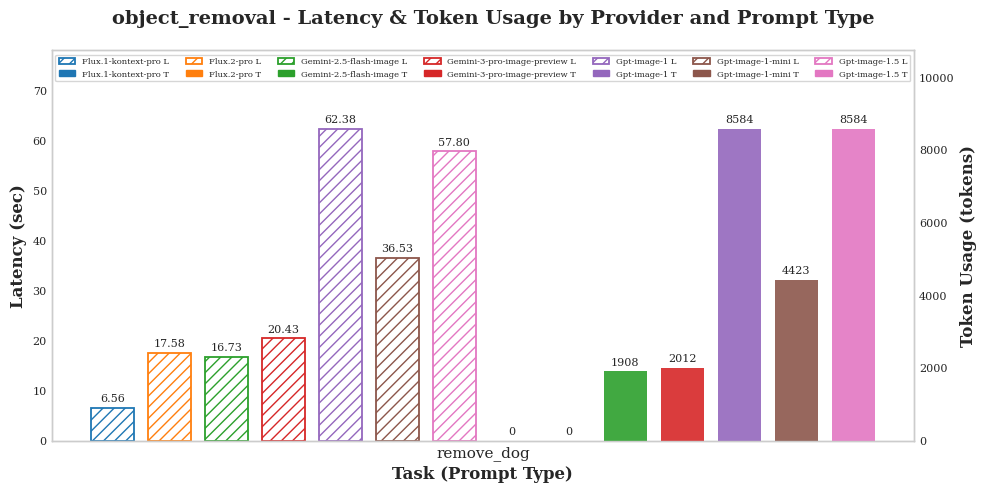

In [92]:
plot_evaluation_results(results)